## The approach we will do this is as such

extract video frames -> train a CNN model with the frames of the videos as a still image -> predict a video by converting it to frames. 

In [1]:
# Create files ./BicepCurl/ and ./ShoulderPress/ for training videos

# Create files ./BicepCurlTest/ and ./ShouldPressTest/ for test videos
import os

def remove_ext(file):
  base=os.path.basename(file)
  return os.path.splitext(base)[0]

In [2]:
# First we convert all videos to frames and store in some path 

from os import listdir
from os.path import isfile, join
bicep_curl_dir = './BicepCurl/'
shoulder_press_dir = './ShoulderPress/'

def get_file_names(mypath):
  onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath,f))]
  return onlyfiles

bicep_curl_names = get_file_names(bicep_curl_dir)
shoulder_press_names = get_file_names(shoulder_press_dir)

In [3]:
!mkdir ./data
!mkdir ./data/BicepCurlFrames
!mkdir ./data/ShoulderPressFrames


In [4]:
#converting all the images to different frames

import cv2
def convert_vid_to_frames(in_path,out_path,file_name):
  vidcap = cv2.VideoCapture(in_path)
  success,image = vidcap.read()
  count = 0
  while success:
    # print(f'./data/{out_path}/{file_name}_frame_{count}.jpg')
    cv2.imwrite(f'./data/{out_path}/{file_name}_frame_{count}.jpg',image)
    success,image = vidcap.read()
    count += 1

In [5]:
for name in bicep_curl_names:
  convert_vid_to_frames(f'./BicepCurl/{name}','BicepCurlFrames',name)


In [6]:
for name in shoulder_press_names:
  convert_vid_to_frames(f'./ShoulderPress/{name}','ShoulderPressFrames',name)

## Simple CNN approach (same as lab 11)

In [7]:
import torch

print("PyTorch version:")
print(torch.__version__)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))


PyTorch version:
1.10.0+cu111
Using cpu device


In [8]:
!pip install torchsummary

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torchsummary import summary
import torch.nn as nn

In [10]:
img_height,img_width = 150,150
input_shape = torch.Tensor((img_height,img_width))
train_data_dir = './data'

classes= ('Bicep Curl', 'Shoulder Press')

In [11]:
# Resize the image and do a center crop, and store them on a tensor
transform = transforms.Compose([transforms.Resize(img_height),transforms.CenterCrop(img_width), transforms.ToTensor()])

# Load the training and validation dataset
train_dataset = datasets.ImageFolder(train_data_dir, transform=transform)

In [12]:
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

In [13]:
batch_size = 30
train_dataloader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True,num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size,num_workers=2)

tensor(1)
This is a Shoulder Press.


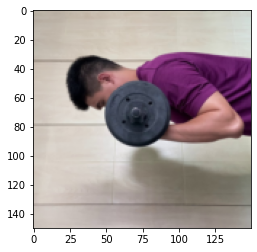

In [14]:
# Print train dataloader
images,labels = next(iter(train_dataloader))
print(labels[0])
print('This is a {}.'.format(classes[labels[0]])) #use this when running on colab
plt.imshow(  images[0].permute(1, 2, 0)  )
# print('This is a {}.'.format(classes[labels[0]-1]))
# plt.imshow(images[0].moveaxis(0,2)) #use this for jupyter hub

tensor(0)
This is a Bicep Curl.


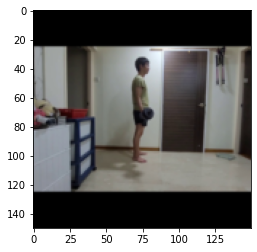

In [15]:
# Print val dataloader
images,labels = next(iter(val_dataloader))
print(labels[0])
print('This is a {}.'.format(classes[labels[0]])) #use this when running on colab
plt.imshow(  images[0].permute(1, 2, 0)  )
# print('This is a {}.'.format(classes[labels[0]-1]))
# plt.imshow(images[0].moveaxis(0,2)) #use this for jupyter hub

In [16]:
def calcsize(model,channum,imh,imw):
  image=torch.rand(channum,imh,imw)
  image=image[None,:]
  output=model(image)
  return output.shape[1:]

#initialise our model
model=nn.Sequential(nn.Conv2d(3, 32, 3),
        nn.BatchNorm2d(32), # Applies Batch Normalization over a 4D input
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Conv2d(32, 32, 3),
        nn.BatchNorm2d(32),# Applies Batch Normalization over a 4D input
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Conv2d(32, 64, 3),
        nn.ReLU(),
        nn.MaxPool2d(2, 2)
        )

channum=3 # number of colour channels - RGB=3

output_size=calcsize(model,channum,img_height,img_width)
print(output_size)

# Now that you know the output size you can extend the model with the last fully connected layers
layers = list(model.children())
layers.extend([nn.Flatten(),
                 nn.Linear(output_size[0]*output_size[1]*output_size[2], 64),
                 nn.Dropout(0.5),
                 nn.Linear(64,1),
                 nn.Sigmoid()
                 ])

# move the model on the GPU
model=nn.Sequential(*layers).to(device)

torch.Size([64, 17, 17])


In [17]:
# Set optimizer and loss function (criterion)
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.0001)
criterion = torch.nn.BCELoss()

# Print summary
summary(model,(3,img_height,img_width)) # using torchsummary

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 148, 148]             896
       BatchNorm2d-2         [-1, 32, 148, 148]              64
              ReLU-3         [-1, 32, 148, 148]               0
         MaxPool2d-4           [-1, 32, 74, 74]               0
            Conv2d-5           [-1, 32, 72, 72]           9,248
       BatchNorm2d-6           [-1, 32, 72, 72]              64
              ReLU-7           [-1, 32, 72, 72]               0
         MaxPool2d-8           [-1, 32, 36, 36]               0
            Conv2d-9           [-1, 64, 34, 34]          18,496
             ReLU-10           [-1, 64, 34, 34]               0
        MaxPool2d-11           [-1, 64, 17, 17]               0
          Flatten-12                [-1, 18496]               0
           Linear-13                   [-1, 64]       1,183,808
          Dropout-14                   

In [18]:
import time


# Train the model
def train(model,dataloader,val_dataloader):
    model.train() #set the mode of the model to train mode
    total_acc, total_count, rep_acc, rep_count = 0, 0, 0, 0
    train_loss, rep_loss=0.0, 0.0
    log_interval = 50
    start_time = time.time() # time the training

    for i, data in enumerate(dataloader):
        inputs, labels = data
        # make sure the data is on the GPU
        labels=labels.reshape(labels.shape[0],1).float().to(device)
        inputs=inputs.to(device)     
        optimizer.zero_grad()

        # forward propagation, i.e. get predictions
        predicted_label = model(inputs)

        # calculate loss and backpropagate to model paramters:
        loss = criterion(predicted_label, labels)
        train_loss += loss.item() # to be reported per epoch
        rep_loss += loss.item() # to be reported per log_interval batches
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)

        # update parameters by stepping the optimizer
        optimizer.step()

        # update the total accuracy to be reported per epoch and batch, and keep track of the loop 
        total_acc += ((predicted_label > 0.5) == labels).sum().item() # to be reported per epoch
        rep_acc += ((predicted_label > 0.5) == labels).sum().item() # to be reported per log_interval batches
        total_count += labels.size(0)
        rep_count += labels.size(0)

        if i % log_interval == 0 and i > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| train_loss {:8.3f} | accuracy {:8.3f} | elapsed time {:5.1f} seconds'.format(epoch, i, len(dataloader),
                                              rep_loss/log_interval, rep_acc/rep_count, elapsed))
            rep_acc, rep_count = 0, 0
            rep_loss=0.0
            start_time = time.time()


    # Make a pass over the validation data.
    val_acc, val_count = 0.0, 0.0
    cum_loss = 0.0
    model.eval()
    with torch.no_grad():
        for j, data in enumerate(val_dataloader):
            inputs, labels = data
            labels=labels.reshape(labels.shape[0],1).float().to(device)
            inputs=inputs.to(device)

            # Forward pass. (Prediction stage)
            scores = model(inputs)
            cum_loss += criterion(scores, labels).item()

            # Count how many correct in this batch.
            val_acc += ((scores > 0.5) == labels).sum().item()
            val_count += labels.size(0)


    # Logging the current results on validation.
    print('Validation-epoch %d. Avg-Val.Loss: %.4f, Val. Accuracy: %.4f' % 
            (epoch, cum_loss / (j + 1), val_acc/val_count))
    return total_acc/total_count, val_acc/val_count, train_loss/(i+1), cum_loss / (j + 1)
      

In [19]:
# Run for 50 epochs to accurately train the model 
ta=[]
va=[]
tl=[]
vl=[]
for epoch in range(3):
  train_acc, val_acc, train_loss, val_loss=train(model,train_dataloader,val_dataloader)
  ta.append(train_acc)
  va.append(val_acc)
  tl.append(train_loss)
  vl.append(val_loss)

| epoch   0 |    50/  182 batches | train_loss    0.104 | accuracy    0.959 | elapsed time  82.7 seconds
| epoch   0 |   100/  182 batches | train_loss    0.000 | accuracy    1.000 | elapsed time  76.8 seconds
| epoch   0 |   150/  182 batches | train_loss    0.000 | accuracy    1.000 | elapsed time  77.7 seconds
Validation-epoch 0. Avg-Val.Loss: 0.0000, Val. Accuracy: 1.0000
| epoch   1 |    50/  182 batches | train_loss    0.000 | accuracy    1.000 | elapsed time  82.9 seconds
| epoch   1 |   100/  182 batches | train_loss    0.000 | accuracy    1.000 | elapsed time  77.8 seconds
| epoch   1 |   150/  182 batches | train_loss    0.000 | accuracy    1.000 | elapsed time  77.5 seconds
Validation-epoch 1. Avg-Val.Loss: 0.0060, Val. Accuracy: 0.9971
| epoch   2 |    50/  182 batches | train_loss    0.000 | accuracy    1.000 | elapsed time  83.1 seconds
| epoch   2 |   100/  182 batches | train_loss    0.000 | accuracy    1.000 | elapsed time  77.8 seconds
| epoch   2 |   150/  182 batche

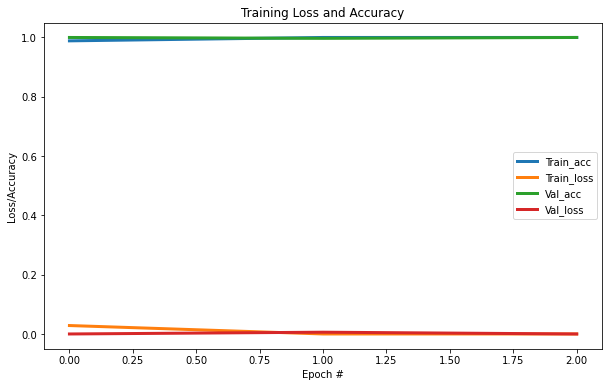

In [20]:
def plotResults(): 
    plt.figure(figsize=(10,6))
    epovec=range(len(ta))
    plt.plot(epovec,ta,epovec,tl,epovec,va,epovec,vl,linewidth=3)
    plt.legend(('Train_acc','Train_loss','Val_acc','Val_loss'))

    # make the graph understandable: 
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.show()
    
plotResults()

In [21]:
!mkdir ./data/test

In [22]:
# Define our testing data
# In a video we predict each frame, then the frames with the highest classification points wins
from PIL import Image
def predict_test_data(file_ext,file,label,label_number):
  convert_vid_to_frames(file_ext,'test',file)
  all_test_frames = [f for f in listdir('./data/test/') if isfile(join('./data/test/',f))]
  test_frames = []
  for files in all_test_frames:
    if file in files:
      test_frames.append(files)

  test_frames.sort()
  actual_list = [label_number for _ in range(len(test_frames))]
  predict_list = []
  # Now that we have all the test frames, we will predict it one by one 
  for frame in test_frames:
    testImg = Image.open(f'./data/test/{frame}')
    testImg = transform(testImg)
    testImg = testImg[None,:].to(device)


    model.eval()
    with torch.no_grad():
      pred_prob=model(testImg)
      pred_class=(pred_prob > 0.5) 
    
    if pred_class == 1:
        prediction = 'Shoulder Press'
        # print("This image is an exercise of "+ prediction + ".")
        # print('With probability of  ' + str(pred_prob.item()))
        predict_list.append(1)
    else:
        prediction = 'Bicep Curl'
        # print("This image is an exercise class of "+ prediction + ".")
        # print('With probability of  ' + str(1-pred_prob.item()))
        predict_list.append(0)

  print(f"accuracy in predicting the video {file} as {label} = {(sum(1 for x,y in zip(actual_list,predict_list) if x == y) / len(predict_list)) * 100}%")


bicep_curl_test_dir = './BicepCurlTest/'
shoulder_press_test_dir = './ShoulderPressTest/'

bicep_curl_test_files = get_file_names(bicep_curl_test_dir)
shoulder_press_test_files = get_file_names(shoulder_press_test_dir)

for file in bicep_curl_test_files:
  predict_test_data(f'./BicepCurlTest/{file}',remove_ext(file),'Bicep Curl',0)
for file in shoulder_press_test_files:
  predict_test_data(f'./ShoulderPressTest/{file}',remove_ext(file),'Shoulder Press',1)

# predict_test_data('SPDiffAngPY17.mp4','SPDiffAngPY17','Shoulder Press',1)
# predict_test_data('ry_good_10.MOV','ry_good_10','Bicep Curl',0)
# predict_test_data('Good 1.mov','Good 1','Bicep Curl',0)
# predict_test_data('SP good 1.mov','SP good 1','Shoulder Press',1)

accuracy in predicting the video Good 2 as Bicep Curl = 100.0%
accuracy in predicting the video Good 1 as Bicep Curl = 100.0%
accuracy in predicting the video Good 9 as Bicep Curl = 100.0%
accuracy in predicting the video Good 4 as Bicep Curl = 100.0%
accuracy in predicting the video Good 10 as Bicep Curl = 100.0%
accuracy in predicting the video Good 11 as Bicep Curl = 62.585034013605444%
accuracy in predicting the video Good 3 as Bicep Curl = 100.0%
accuracy in predicting the video Good 7 as Bicep Curl = 85.60311284046692%
accuracy in predicting the video Good 3 as Bicep Curl = 84.85523385300668%
accuracy in predicting the video Good 12 as Bicep Curl = 45.86466165413533%
accuracy in predicting the video Good 13 as Bicep Curl = 100.0%
accuracy in predicting the video Good 8 as Bicep Curl = 100.0%
accuracy in predicting the video Good 6 as Bicep Curl = 100.0%
accuracy in predicting the video SP good 1 as Shoulder Press = 0.0%
accuracy in predicting the video SP good 2 as Shoulder Press

## Results
For Images already on training set 100% correct

For Images NOT on training set, it always predicts Bicep Curl no matter the type of video. 

## Augmented Data Model

In [23]:
augtransforms=transforms.Compose([transforms.Resize((150,150)),
transforms.RandomAffine(degrees=(-25,25),translate=(0.1,0.1),shear=(-7,7)),
transforms.RandomResizedCrop((150,150),scale=(0.8,1),ratio=(0.9,1.1)),
transforms.RandomHorizontalFlip(),
transforms.ToTensor()]) # don't forget to add ToTensor when using the DataLoader

batch_size = 30
augtrain_dataset = datasets.ImageFolder(train_data_dir, transform=augtransforms) # our new augmented dataset
augtrain_dataloader = DataLoader(augtrain_dataset, batch_size=batch_size,shuffle=True,num_workers=2) #and our new dataloader for this set

val_dataloader = DataLoader(val_dataset, batch_size=batch_size,num_workers=2)

In [24]:
augmodel = nn.Sequential(*layers).to(device) # set the model to be the same model as before, but with weights reinitilized
optimizer = torch.optim.RMSprop(augmodel.parameters(), lr=0.0001)
criterion = torch.nn.BCELoss()

In [25]:
# Epochs set to 30 because training takes much longer even with GPU 
ta=[]
va=[]
tl=[]
vl=[]
for epoch in range(3):
  train_acc, val_acc, train_loss, val_loss=train(augmodel,augtrain_dataloader,val_dataloader)
  ta.append(train_acc)
  va.append(val_acc)
  tl.append(train_loss)
  vl.append(val_loss)

| epoch   0 |    50/  324 batches | train_loss    1.049 | accuracy    0.358 | elapsed time 104.6 seconds
| epoch   0 |   100/  324 batches | train_loss    5.933 | accuracy    0.382 | elapsed time  98.5 seconds
| epoch   0 |   150/  324 batches | train_loss    2.333 | accuracy    0.378 | elapsed time  97.9 seconds
| epoch   0 |   200/  324 batches | train_loss    3.067 | accuracy    0.387 | elapsed time  96.0 seconds
| epoch   0 |   250/  324 batches | train_loss    4.011 | accuracy    0.378 | elapsed time  98.7 seconds
| epoch   0 |   300/  324 batches | train_loss   -7.852 | accuracy    0.409 | elapsed time  97.1 seconds
Validation-epoch 0. Avg-Val.Loss: 0.5217, Val. Accuracy: 0.9617
| epoch   1 |    50/  324 batches | train_loss  -19.561 | accuracy    0.618 | elapsed time 100.2 seconds
| epoch   1 |   100/  324 batches | train_loss  -25.874 | accuracy    0.627 | elapsed time  97.7 seconds
| epoch   1 |   150/  324 batches | train_loss  -26.626 | accuracy    0.649 | elapsed time  97.8

In [26]:
# Define our testing data
# In a video we predict each frame, then the frames with the highest classification points wins
from PIL import Image
def predict_test_data_aug(file_ext,file,label,label_number):
  convert_vid_to_frames(file_ext,'test',file)
  all_test_frames = [f for f in listdir('./data/test/') if isfile(join('./data/test/',f))]
  test_frames = []
  for files in all_test_frames:
    if file in files:
      test_frames.append(files)

  test_frames.sort()

  # Now that we have all the test frames, we will predict it one by one 
  for frame in test_frames:
    testImg = Image.open(f'./data/test/{frame}')
    testImg = transform(testImg)
    testImg = testImg[None,:].to(device)

    actual_list = [label_number for _ in range(len(test_frames))]
    predict_list = []
    augmodel.eval()
    with torch.no_grad():
      pred_prob=augmodel(testImg)
      pred_class=(pred_prob > 0.5) 
    
    if pred_class == 1:
        prediction = 'Bicep Curl'
        # print("This image is an exercise of "+ prediction + ".")
        # print('With probability of  ' + str(pred_prob.item()))
        predict_list.append(1)
    else:
        prediction = 'Shoulder Press'
        # print("This image is an exercise class of "+ prediction + ".")
        # print('With probability of  ' + str(1-pred_prob.item()))
        predict_list.append(0)

  print(f"accuracy in predicting the {file_ext} as {label} = {(sum(1 for x,y in zip(actual_list,predict_list) if x == y) / len(predict_list)) * 100}%")


bicep_curl_test_dir = './BicepCurlTest/'
shoulder_press_test_dir = './ShoulderPressTest/'

bicep_curl_test_files = get_file_names(bicep_curl_test_dir)
shoulder_press_test_files = get_file_names(shoulder_press_test_dir)

for file in bicep_curl_test_files:
  predict_test_data_aug(f'./BicepCurlTest/{file}',remove_ext(file),'Bicep Curl',0)
for file in shoulder_press_test_files:
  predict_test_data_aug(f'./ShoulderPressTest/{file}',remove_ext(file),'Shoulder Press',1)

accuracy in predicting the ./BicepCurlTest/Good 2.mov as Bicep Curl = 0.0%
accuracy in predicting the ./BicepCurlTest/Good 1.mov as Bicep Curl = 0.0%
accuracy in predicting the ./BicepCurlTest/Good 9.mov as Bicep Curl = 0.0%
accuracy in predicting the ./BicepCurlTest/Good 4.mov as Bicep Curl = 0.0%
accuracy in predicting the ./BicepCurlTest/Good 10.mov as Bicep Curl = 0.0%
accuracy in predicting the ./BicepCurlTest/Good 11.mov as Bicep Curl = 0.0%
accuracy in predicting the ./BicepCurlTest/Good 3.mp3 as Bicep Curl = 0.0%
accuracy in predicting the ./BicepCurlTest/Good 7.mov as Bicep Curl = 0.0%
accuracy in predicting the ./BicepCurlTest/Good 3.mov as Bicep Curl = 0.0%
accuracy in predicting the ./BicepCurlTest/Good 12.mov as Bicep Curl = 0.0%
accuracy in predicting the ./BicepCurlTest/Good 13.mov as Bicep Curl = 0.0%
accuracy in predicting the ./BicepCurlTest/Good 8.mov as Bicep Curl = 0.0%
accuracy in predicting the ./BicepCurlTest/Good 6.mov as Bicep Curl = 0.0%
accuracy in predictin

## Using a pretrained model VGG for classification

In [27]:
!pip install torchvision

In [28]:
import torchvision.models as models
import torch.nn as nn
model_vgg=models.vgg16(pretrained=True).to(device) #import the vgg16 model
#model_vgg=models.vgg16_bn(pretrained=True) #FYI this model is enhanced with Batch_normalization layers
print(model_vgg) #Let's look at the model

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [29]:
#we can freeze the weights by disabling gradient for the parameters, it should not be necessary in our case, since we do not plan to train the whole model, but FYI
for param in model_vgg.features.parameters(): #disabling gradient in the 'features' part of the model (convolutional part)
    param.require_grad = False #tell the model to keep the weights fixed

num_features = model_vgg.classifier[6].in_features #get the number of inputs for the very last layer
features = list(model_vgg.classifier.children())[:-1] # Remove last layer

# Newly created modules have require_grad=True by default
features.extend([nn.Linear(num_features, 1)]) # Add our layer with 1 output for binary classification
model_vgg.classifier = nn.Sequential(*features).to(device) # Replace the final classification layer
print("features",features)
print(model_vgg)

features [Linear(in_features=25088, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=1, bias=True)]
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
  

In [30]:
batch_size=100

train_dataloader_forvgg = DataLoader(train_dataset, batch_size=batch_size,shuffle=False,num_workers=2)
val_dataloader_forvgg = DataLoader(val_dataset, batch_size=batch_size,shuffle=False,num_workers=2)

In [31]:
#defining a function that will run the data through the 'features' and 'avgpool' parts of the model
def gimmefeatures(model_vgg,dataloader):
  model_vgg.eval()
  output=torch.zeros((len(dataloader.dataset),512,7,7))
  label=torch.zeros((len(dataloader.dataset)))
  i=0

  with torch.no_grad():
    for j, data in enumerate(dataloader):
        inputs, labels = data
        inputs=inputs.to(device)
        outputs=model_vgg.avgpool(model_vgg.features(inputs))
        output[i:i+outputs.shape[0],:,:,:]=outputs
        print(output)
        label[i:i+labels.shape[0]]=labels
        i=i+outputs.shape[0]
        print(i)

  return output, label

In [32]:
train_feats, train_labels=gimmefeatures(model_vgg,train_dataloader_forvgg)

# move this to GPU
train_feats=train_feats.to(device)
train_labels=train_labels.to(device)

torch.save((train_feats,train_labels),'train_data.pt')

Streaming output truncated to the last 5000 lines.
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]]],


        ...,


        [[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
    

In [33]:
# same for validation data
val_feats, val_labels=gimmefeatures(model_vgg,val_dataloader_forvgg)

val_feats=val_feats.to(device)
val_labels=val_labels.to(device)

torch.save((val_feats,val_labels),'val_data.pt')

Streaming output truncated to the last 5000 lines.
           0.0000e+00, 0.0000e+00],
          [1.1722e-01, 1.4100e+00, 2.7027e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 1.0761e+00, 2.1523e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]]],


        ...,


        [[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
    

In [34]:
train_feats,train_labels=torch.load('train_data.pt')
val_feats,val_labels=torch.load('val_data.pt')

In [35]:
batch_size=30
train_feat_dataset = torch.utils.data.TensorDataset(train_feats,train_labels)
train_feat_dataloader = DataLoader(train_feat_dataset,batch_size=batch_size,shuffle=True,num_workers=0)

val_feat_dataset = torch.utils.data.TensorDataset(val_feats,val_labels)
val_feat_dataloader = DataLoader(val_feat_dataset,batch_size=30,shuffle=True,num_workers=0)

In [36]:
#check that it works - we should be getting two tensors - features, and labels of sizes [batch_size,512,7,7] and [batch_size]
feata,laba=next(iter(train_feat_dataloader))
print(feata.shape)
print(laba.shape)

torch.Size([30, 512, 7, 7])
torch.Size([30])


In [37]:
def train_vgg_classifier(modelclassifier,dataloader,val_dataloader):
    modelclassifier.train() #set the mode of the model to train mode
    total_acc, total_count, rep_acc, rep_count = 0, 0, 0, 0
    train_loss, rep_loss=0.0, 0.0
    log_interval = 50
    start_time = time.time()

    for i, data in enumerate(dataloader):
        inputs, labels = data
        labels=labels.reshape(labels.shape[0],1).float().to(device)
        inputs=inputs.to(device)
        labels=labels.to(device)

        optimizer.zero_grad()
        # forward propagation
        predicted_label = torch.sigmoid(modelclassifier(torch.flatten(inputs,start_dim=1)))

        # calculate loss and backpropagate to model paramters
        loss = criterion(predicted_label, labels)
        train_loss += loss.item() # to be reported per epoch
        rep_loss += loss.item() # to be reported per log_interval batches
        loss.backward()
        torch.nn.utils.clip_grad_norm_(modelclassifier.parameters(), 0.1)
        # update parameters by stepping the optimizer
        optimizer.step()
        total_acc += ((predicted_label > 0.5) == labels).sum().item() # to be reported per epoch
        rep_acc += ((predicted_label > 0.5) == labels).sum().item() # to be reported per log_interval batches
        total_count += labels.size(0)
        rep_count += labels.size(0)

        if i % log_interval == 0 and i > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| train_loss {:8.3f} | accuracy {:8.3f} | elapsed time {:5.1f} seconds'.format(epoch, i, len(dataloader),
                                              rep_loss/log_interval, rep_acc/rep_count, elapsed))
            rep_acc, rep_count = 0, 0
            rep_loss=0.0
            start_time = time.time()


          # Make a pass over the validation data.
    val_acc, val_count = 0.0, 0.0
    cum_loss = 0.0
    start_time = time.time()
    modelclassifier.eval()

    with torch.no_grad():
        for j, data in enumerate(val_dataloader):
            inputs, labels = data
            labels=labels.reshape(labels.shape[0],1).float().to(device)
            inputs=inputs.to(device)

            # Forward pass. (Prediction stage)
            scores = torch.sigmoid(modelclassifier(torch.flatten(inputs,start_dim=1)))
            cum_loss += criterion(scores, labels).item()

            # Count how many correct in this batch.
            val_acc += ((scores > 0.5) == labels).sum().item()
            val_count += labels.size(0)

    elapsed = time.time() - start_time
    # Logging the current results on validation.
    print('Validation-epoch %d. Avg-Val Loss: %.4f, Val Accuracy: %.4f,   Elapsed Time: %.1f' % 
            (epoch, cum_loss / (j + 1), val_acc/val_count,elapsed))
    return total_acc/total_count, val_acc/val_count, train_loss/(i+1), cum_loss / (j + 1)


def evaluate_vgg(model,dataloader):
    model.eval()
    total_acc, total_count = 0, 0
    wrong=torch.zeros((len(dataloader.dataset)),1)
    j=0
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            inputs, labels = data
            inputs=inputs.to(device)
            labels=labels.reshape(labels.shape[0],1).float().to(device)
            predicted_label = torch.sigmoid(model(inputs))
            correct=((predicted_label > 0.5) == labels)
            total_acc += correct.sum().item()
            total_count += labels.size(0)
            wrong[j:j+labels.size(0),:]=~correct
            j=j+labels.size(0)
    return total_acc/total_count, wrong

In [38]:
optimizer = torch.optim.RMSprop(model_vgg.classifier.parameters(), lr=0.0001)
criterion = torch.nn.BCELoss()

In [39]:
ta=[]
va=[]
tl=[]
vl=[]
for epoch in range(3):
  train_acc, val_acc, train_loss, val_loss=train_vgg_classifier(model_vgg.classifier,train_feat_dataloader,val_feat_dataloader)
  ta.append(train_acc)
  va.append(val_acc)
  tl.append(train_loss)
  vl.append(val_loss)

| epoch   0 |    50/  182 batches | train_loss    0.114 | accuracy    0.969 | elapsed time  80.4 seconds
| epoch   0 |   100/  182 batches | train_loss    0.000 | accuracy    1.000 | elapsed time  77.7 seconds
| epoch   0 |   150/  182 batches | train_loss    0.000 | accuracy    1.000 | elapsed time  77.8 seconds
Validation-epoch 0. Avg-Val Loss: 0.0000, Val Accuracy: 1.0000,   Elapsed Time: 8.5
| epoch   1 |    50/  182 batches | train_loss    0.000 | accuracy    1.000 | elapsed time  80.7 seconds
| epoch   1 |   100/  182 batches | train_loss    0.000 | accuracy    1.000 | elapsed time  80.5 seconds
| epoch   1 |   150/  182 batches | train_loss    0.000 | accuracy    1.000 | elapsed time  80.4 seconds
Validation-epoch 1. Avg-Val Loss: 0.0000, Val Accuracy: 1.0000,   Elapsed Time: 8.6
| epoch   2 |    50/  182 batches | train_loss    0.000 | accuracy    1.000 | elapsed time  82.1 seconds
| epoch   2 |   100/  182 batches | train_loss    0.000 | accuracy    1.000 | elapsed time  80.9 

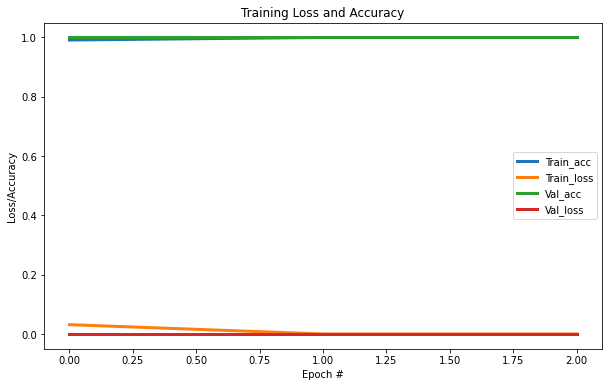

In [40]:
plotResults()

In [42]:
# Define our testing data
# In a video we predict each frame, then the frames with the highest classification points wins
from PIL import Image
def predict_test_data_vgg(file_ext,file,label,label_number):
  convert_vid_to_frames(file_ext,'test',file)
  all_test_frames = [f for f in listdir('./data/test/') if isfile(join('./data/test/',f))]
  test_frames = []
  for files in all_test_frames:
    if file in files:
      test_frames.append(files)

  test_frames.sort()

  # Now that we have all the test frames, we will predict it one by one 
  for frame in test_frames:
    testImg = Image.open(f'./data/test/{frame}')
    testImg = transform(testImg)
    testImg = testImg[None,:].to(device)

    actual_list = [label_number for _ in range(len(test_frames))]
    predict_list = []
    model_vgg.eval()
    with torch.no_grad():
      pred_prob=torch.sigmoid(model_vgg(testImg))
      pred_class=(pred_prob > 0.5) 
    
    if pred_class == 1:
        prediction = 'Bicep Curl'
        # print("This image is an exercise of "+ prediction + ".")
        # print('With probability of  ' + str(pred_prob.item()))
        predict_list.append(1)
    else:
        prediction = 'Shoulder Press'
        # print("This image is an exercise class of "+ prediction + ".")
        # print('With probability of  ' + str(1-pred_prob.item()))
        predict_list.append(0)

  print(f"accuracy in predicting the video {file_ext} as {label} = {(sum(1 for x,y in zip(actual_list,predict_list) if x == y) / len(predict_list)) * 100}%")

bicep_curl_test_dir = './BicepCurlTest/'
shoulder_press_test_dir = './ShoulderPressTest/'

bicep_curl_test_files = get_file_names(bicep_curl_test_dir)
shoulder_press_test_files = get_file_names(shoulder_press_test_dir)

for file in bicep_curl_test_files:
  predict_test_data_vgg(f'./BicepCurlTest/{file}',remove_ext(file),'Bicep Curl',0)
for file in shoulder_press_test_files:
  predict_test_data_vgg(f'./ShoulderPressTest/{file}',remove_ext(file),'Shoulder Press',1)

accuracy in predicting the video ./BicepCurlTest/Good 2.mov as Bicep Curl = 0.0%
accuracy in predicting the video ./BicepCurlTest/Good 1.mov as Bicep Curl = 100.0%
accuracy in predicting the video ./BicepCurlTest/Good 9.mov as Bicep Curl = 100.0%
accuracy in predicting the video ./BicepCurlTest/Good 4.mov as Bicep Curl = 100.0%
accuracy in predicting the video ./BicepCurlTest/Good 10.mov as Bicep Curl = 0.0%
accuracy in predicting the video ./BicepCurlTest/Good 11.mov as Bicep Curl = 0.0%
accuracy in predicting the video ./BicepCurlTest/Good 3.mp3 as Bicep Curl = 100.0%
accuracy in predicting the video ./BicepCurlTest/Good 7.mov as Bicep Curl = 0.0%
accuracy in predicting the video ./BicepCurlTest/Good 3.mov as Bicep Curl = 100.0%
accuracy in predicting the video ./BicepCurlTest/Good 12.mov as Bicep Curl = 0.0%
accuracy in predicting the video ./BicepCurlTest/Good 13.mov as Bicep Curl = 100.0%
accuracy in predicting the video ./BicepCurlTest/Good 8.mov as Bicep Curl = 0.0%
accuracy in 

In [ ]:
## Prevents the  colab from disconnecting
while True:pass